In [1]:
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, balanced_accuracy_score

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df_vfc = pd.read_csv("vfc_dataset_janela-35_fs-80.csv")

### Tratando dados nulos

In [3]:
cols_drop = df_vfc[df_vfc.columns[df_vfc.isin([np.nan, np.inf, -np.inf]).any(0)]].columns

C:\Users\Ana\AppData\Local\Temp\ipykernel_14940\3876734435.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  cols_drop = df_vfc[df_vfc.columns[df_vfc.isin([np.nan, np.inf, -np.inf]).any(0)]].columns


In [4]:
cols_drop

Index(['mean_hr', 'max_hr', 'std_hr', 'lf_hf_ratio', 'lfnu', 'hfnu'], dtype='object')

In [5]:
print("Antes de remover os dados nulos e infitos: ", df_vfc.shape)

df_vfc_clean = df_vfc.drop(columns=cols_drop)

print("Depois de remover os dados nulos e infitos: ", df_vfc_clean.shape)

Antes de remover os dados nulos e infitos:  (2112, 24)
Depois de remover os dados nulos e infitos:  (2112, 18)


### Normalizando os dados

In [6]:
X = df_vfc_clean.drop(["labels"],axis=1)
Y = df_vfc_clean["labels"]

cols = X.columns.tolist()

scaler_features = StandardScaler()

df_scaled= scaler_features.fit_transform(X)
df_scaled = pd.DataFrame(df_scaled, columns=cols)   

df_scaled.reset_index(drop=True,inplace=True)

Y.reset_index(drop=True, inplace=True)

df_scaled["labels"] = Y.copy()

In [7]:
df_scaled.head()

,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,min_hr,lf,hf,total_power,vlf,labels
0,-2.818292,-0.910539,-0.877427,0.0,0.0,0.0,0.0,-0.877649,-2.811033,-0.833402,-0.681656,-0.664116,4.476742,-0.205216,-0.205240,-0.205233,-0.205212,1
1,-2.692895,-0.848541,-0.864544,0.0,0.0,0.0,0.0,-0.864502,-2.687863,-0.750254,-0.671404,-0.585711,4.079976,-0.227132,-0.227157,-0.227150,-0.227129,1
2,-2.364025,2.671538,0.188064,0.0,0.0,0.0,0.0,0.216279,-2.811033,1.522476,0.804930,4.160422,-0.242937,-0.166436,-0.166459,-0.166452,-0.166433,1
3,0.534292,-0.313988,-0.060656,0.0,0.0,0.0,0.0,-0.061500,0.596661,-0.279078,-0.140102,-0.364037,-0.388362,-0.196770,-0.196797,-0.196789,-0.196767,1
4,-0.425110,2.225900,1.528520,0.0,0.0,0.0,0.0,1.526867,-0.019187,1.051300,1.518384,2.138375,-0.089389,-0.180035,-0.180064,-0.180055,-0.180031,1


### Escolha das features

In [8]:
x_train, x_test, y_train, y_test = train_test_split(df_scaled.drop(columns=['labels']), df_scaled['labels'], random_state=42)

c:\Users\Ana\Documents\biomedica\informatica_medica\venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [3 4 5 6] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Ana\Documents\biomedica\informatica_medica\venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


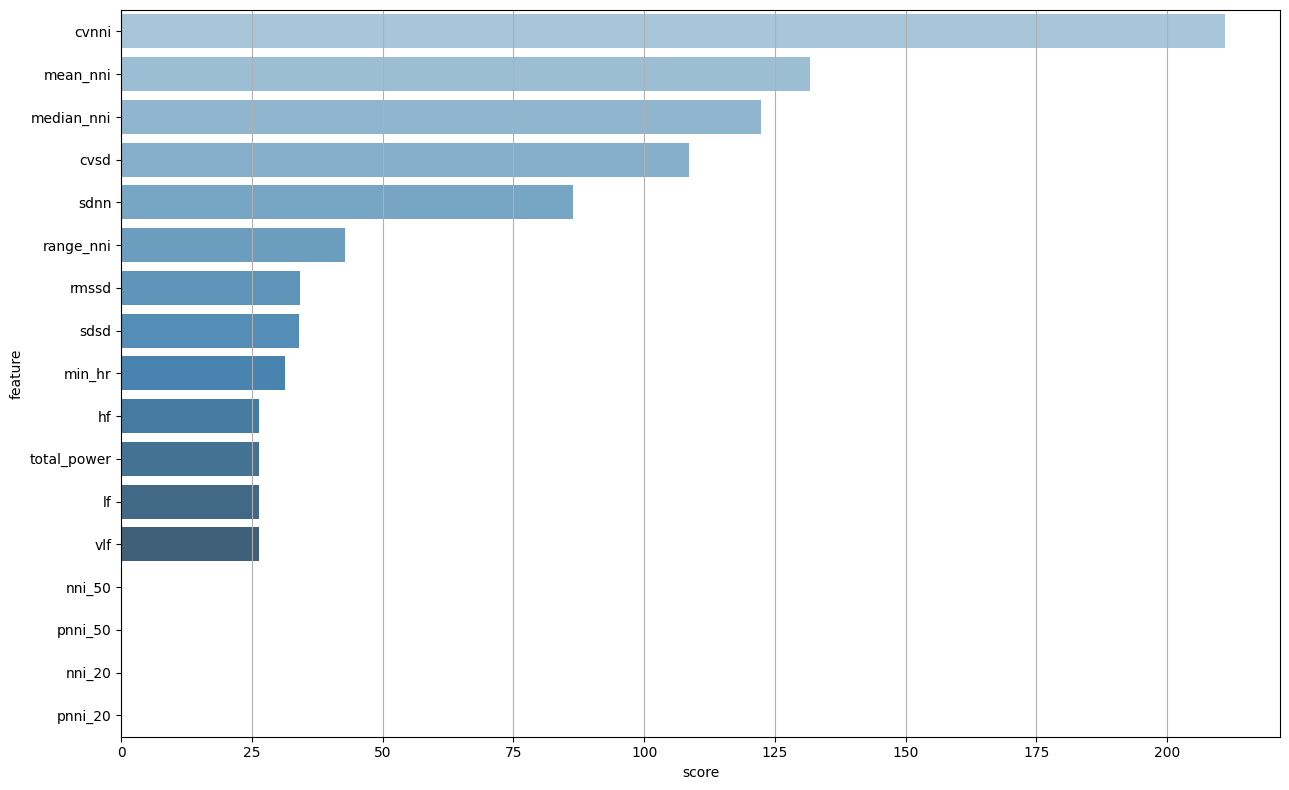

In [9]:
features_to_use = SelectKBest(k='all')

features_fit = features_to_use.fit(x_train, y_train)

df_scores = pd.DataFrame({'feature': x_train.columns.tolist(), 'score': list(features_fit.scores_)})
df_scores.sort_values(by='score', axis=0, ascending=False, inplace=True)

plt.figure(figsize=(13,8))
plt.grid(True)
sns.barplot(x=df_scores.score, y=df_scores.feature, palette='Blues_d')
plt.tight_layout()

In [10]:
cols_select = ['mean_nni', 'median_nni', 'cvnni', 'cvsd', 'min_hr', 'sdnn', 'range_nni', 'sdsd', 'rmssd']

x_train = x_train[cols_select]

x_test = x_test[cols_select]

### Random Forest Classifier

In [11]:
n_iter = 20

In [12]:
param_search = {'n_estimators': [400],
                  'oob_score': [False],
                  'criterion': ['gini'],
                  'bootstrap':[True],
                  'class_weight':['balanced_subsample'],
                  'min_weight_fraction_leaf':[0, 0.1, 0.2, 0.3, 0.4, 0.5], 
                  'min_impurity_decrease':[0, 0.1],
                  'min_samples_split': [10, 30, 60, 80],
                  'min_samples_leaf': [10, 30, 60, 80]
                 }
            
cv = RepeatedStratifiedKFold(n_splits=5, 
                    n_repeats=3, 
                    random_state=42)

rs_rf = RandomizedSearchCV(RandomForestClassifier(n_jobs=1),
                        param_distributions=param_search,
                        n_iter=n_iter,
                        scoring='f1',
                        random_state=42,
                        n_jobs=-1,
                        cv=cv)

rs_rf.fit(x_train, y_train)

model, best_score = rs_rf.best_estimator_, rs_rf.best_score_

y_pred_test_rf = model.predict(x_test)
y_pred_train_rf = model.predict(x_train)

In [13]:
print("Verificar overfitting do modelo")
print("Balanced Acc. Test: ", balanced_accuracy_score(y_test, y_pred_test_rf))
print("Balanced Acc. Train: ", balanced_accuracy_score(y_train, y_pred_train_rf))

Verificar overfitting do modelo
Balanced Acc. Test:  0.9125
Balanced Acc. Train:  0.9365335051546392


In [14]:
print(classification_report(y_test, y_pred_test_rf))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       520
           1       0.21      0.88      0.34         8

    accuracy                           0.95       528
   macro avg       0.61      0.91      0.66       528
weighted avg       0.99      0.95      0.96       528



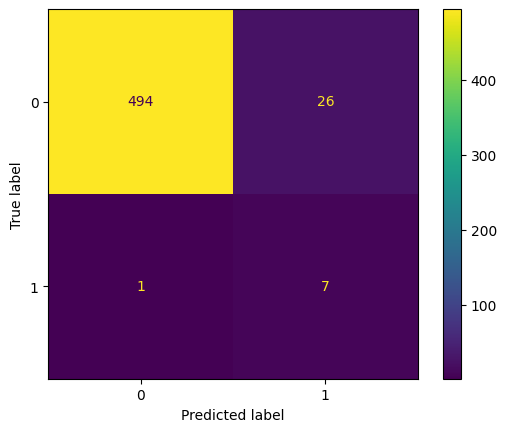

In [15]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_rf)

### LogisticRegression

In [16]:
lr = LogisticRegression(random_state=42)
lr.fit(x_train, y_train)
y_pred_lr = lr.predict(x_test)
y_pred_train_lr = lr.predict(x_train)

In [17]:
print("Verificar overfitting do modelo")
print("Balanced Acc. Test: ", balanced_accuracy_score(y_test, y_pred_lr))
print("Balanced Acc. Train: ", balanced_accuracy_score(y_train, y_pred_train_lr))

Verificar overfitting do modelo
Balanced Acc. Test:  0.6846153846153846
Balanced Acc. Train:  0.623389175257732


In [18]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       520
           1       0.50      0.38      0.43         8

    accuracy                           0.98       528
   macro avg       0.75      0.68      0.71       528
weighted avg       0.98      0.98      0.98       528



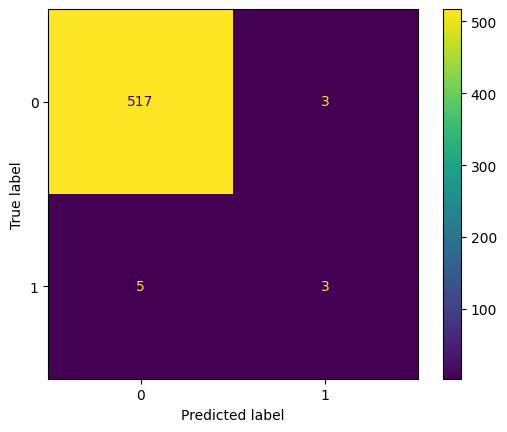

In [19]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr)

### KNeighborsClassifier

In [20]:
param_search = {'n_neighbors': np.arange(5, 100,5),
                'weights':['uniform', 'distance'],
                'algorithm':['auto']
                }
            
cv = RepeatedStratifiedKFold(n_splits=5, 
                    n_repeats=3, 
                    random_state=42)



rs_neigh = RandomizedSearchCV(KNeighborsClassifier(n_jobs=1),
                        param_distributions=param_search,
                        n_iter=n_iter,
                        scoring='f1',
                        random_state=42,
                        n_jobs=-1,
                        cv=cv)

rs_neigh.fit(x_train, y_train)

model, best_score = rs_neigh.best_estimator_, rs_neigh.best_score_

y_pred_test_neigh = model.predict(x_test)
y_pred_train_neigh = model.predict(x_train)

In [21]:
print("Verificar overfitting do modelo")
print("Balanced Acc. Test: ", balanced_accuracy_score(y_test, y_pred_test_neigh))
print("Balanced Acc. Train: ", balanced_accuracy_score(y_train, y_pred_train_neigh))

Verificar overfitting do modelo
Balanced Acc. Test:  0.6240384615384615
Balanced Acc. Train:  0.59375


In [22]:
print(classification_report(y_test, y_pred_test_neigh))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       520
           1       0.67      0.25      0.36         8

    accuracy                           0.99       528
   macro avg       0.83      0.62      0.68       528
weighted avg       0.98      0.99      0.98       528



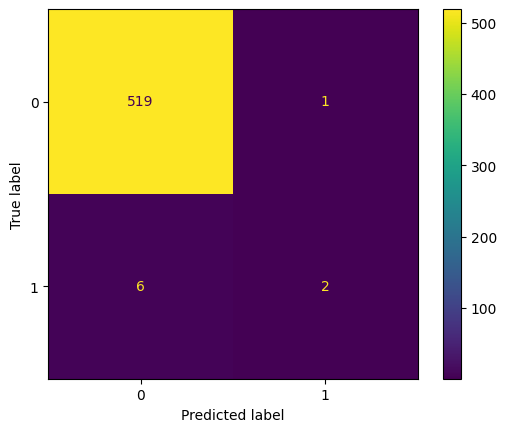

In [23]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_neigh)